<a href="https://colab.research.google.com/github/aa23amd/HYBRID-ML-BASED-SUB-SEASONAL-WEATHER-FORECASTING/blob/main/hybrid_model_evaluation_and_predictions_with_classification_matrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip -o "/content/drive/MyDrive/train_data.csv.zip" -d /content/

Archive:  /content/drive/MyDrive/train_data.csv.zip
  inflating: /content/train_data.csv  


In [3]:

!unzip -o "/content/drive/MyDrive/test_data.csv.zip" -d /content/

Archive:  /content/drive/MyDrive/test_data.csv.zip
  inflating: /content/test_data.csv  


data loading

In [7]:

import pandas as pd

# Load the training data
train_df = pd.read_csv("/content/train_data.csv")
print("Training Data:")
print(train_df.head())

# Load the test data
test_df = pd.read_csv("/content/test_data.csv")
print("\nTest Data:")
print(test_df.head())

# Load dataset from drive
df = pd.read_csv("/content/train_data.csv")

# Display dataset overview
print(df.info())
print(df.head())

Training Data:
   index  lat       lon startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
0      0  0.0  0.833333    9/1/14                              237.00   
1      1  0.0  0.833333    9/2/14                              228.90   
2      2  0.0  0.833333    9/3/14                              220.69   
3      3  0.0  0.833333    9/4/14                              225.28   
4      4  0.0  0.833333    9/5/14                              237.24   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                     29.02                     31.64   
1                     29.02                     31.64   
2                     29.02                     31.64   
3                     29.02                     31.64   
4                     29.02                     31.64   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                    29.57                    30.73                    29.71   
1                    29.57                 

feature selection and target variables

In [8]:
print(df.columns)

Index(['index', 'lat', 'lon', 'startdate',
       'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30',
       'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30',
       'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20',
       ...
       'wind-vwnd-925-2010-11', 'wind-vwnd-925-2010-12',
       'wind-vwnd-925-2010-13', 'wind-vwnd-925-2010-14',
       'wind-vwnd-925-2010-15', 'wind-vwnd-925-2010-16',
       'wind-vwnd-925-2010-17', 'wind-vwnd-925-2010-18',
       'wind-vwnd-925-2010-19', 'wind-vwnd-925-2010-20'],
      dtype='object', length=246)


setting target variables

In [9]:
# Define the target column (sub-seasonal temperature prediction)
target_col = "contest-tmp2m-14d__tmp2m"

# Drop unnecessary columns (Check and modify accordingly)
drop_cols = ['index', 'startdate']  # 'startdate' is likely the date column

# Define features and target
X = df.drop(columns=[target_col] + drop_cols, errors='ignore')  # 'errors=ignore' prevents errors if column doesn't exist
y = df[target_col]

In [10]:
print(X.columns)  # Check the remaining features
print(y.head())   # Check target variable

Index(['lat', 'lon', 'contest-pevpr-sfc-gauss-14d__pevpr',
       'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40',
       'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40',
       'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0',
       'nmme0-tmp2m-34w__gfdlflorb0',
       ...
       'wind-vwnd-925-2010-11', 'wind-vwnd-925-2010-12',
       'wind-vwnd-925-2010-13', 'wind-vwnd-925-2010-14',
       'wind-vwnd-925-2010-15', 'wind-vwnd-925-2010-16',
       'wind-vwnd-925-2010-17', 'wind-vwnd-925-2010-18',
       'wind-vwnd-925-2010-19', 'wind-vwnd-925-2010-20'],
      dtype='object', length=243)
0    28.744480
1    28.370585
2    28.133059
3    28.256798
4    28.372353
Name: contest-tmp2m-14d__tmp2m, dtype: float64


feature scalling

In [11]:
print(X.dtypes)

lat                                   float64
lon                                   float64
contest-pevpr-sfc-gauss-14d__pevpr    float64
nmme0-tmp2m-34w__cancm30              float64
nmme0-tmp2m-34w__cancm40              float64
                                       ...   
wind-vwnd-925-2010-16                 float64
wind-vwnd-925-2010-17                 float64
wind-vwnd-925-2010-18                 float64
wind-vwnd-925-2010-19                 float64
wind-vwnd-925-2010-20                 float64
Length: 243, dtype: object


In [12]:
# Convert categorical columns using One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

print("Dataset shape after encoding:", X.shape)

Dataset shape after encoding: (375734, 256)


In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the dataset
X_scaled = scaler.fit_transform(X)

print("Scaling successful! Shape:", X_scaled.shape)

Scaling successful! Shape: (375734, 256)


data splitting

In [14]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM (LSTM requires 3D input: samples, time steps, features)
X_lstm_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_lstm_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"XGBoost Input Shape: {X_train.shape}")
print(f"LSTM Input Shape: {X_lstm_train.shape}")

XGBoost Input Shape: (300587, 256)
LSTM Input Shape: (300587, 1, 256)


xgboost model training

In [15]:
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predict using XGBoost
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Training Completed ✅")

XGBoost Training Completed ✅


residual computing for LSTM

In [17]:
# Compute residuals (actual - XGBoost prediction)
residuals_train = y_train - xgb_model.predict(X_train)
residuals_test = y_test - xgb_preds

print("Residuals Computed ✅")

Residuals Computed ✅


LSTM training

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

# Compile LSTM model
lstm_model.compile(loss='mae', optimizer='adam')

# Train the LSTM model
lstm_model.fit(X_lstm_train, residuals_train, epochs=15, batch_size=32, validation_data=(X_lstm_test, residuals_test))

print("LSTM Training Completed ✅")

Epoch 1/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - loss: nan - val_loss: nan
Epoch 2/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: nan - val_loss: nan
Epoch 3/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: nan - val_loss: nan
Epoch 4/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: nan - val_loss: nan
Epoch 5/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: nan - val_loss: nan
Epoch 6/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: nan - val_loss: nan
Epoch 7/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - loss: nan - val_loss: nan
Epoch 8/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - loss: nan - val_loss: nan
Epoch 9/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - loss: nan - val_loss: nan
Epoch 10/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: nan - val_loss: nan
Epoch 11/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - loss: nan - val_loss: nan
Epoch 12/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - loss: nan - val_loss: nan
E

Now as in LSTM model traing the the output is showing and generating the nan values, we have to fix this before making predictions. we will now start debugging and find the features with nan . afterv that nan filling will be applied to fix this issue.

debugging

In [21]:
import numpy as np  # Add this line

print("NaNs in X_lstm_train:", np.isnan(X_lstm_train).sum())
print("NaNs in residuals_train:", np.isnan(residuals_train).sum())



NaNs in X_lstm_train: 81376
NaNs in residuals_train: 0


list of features with nan values

In [22]:
print("Columns with NaNs in X_train:")
print(pd.DataFrame(X_train).isnull().sum()[pd.DataFrame(X_train).isnull().sum() > 0])

Columns with NaNs in X_train:
5     12740
16     8227
27     6992
38    12729
48    12740
60     8227
72     6992
88    12729
dtype: int64


now the above are the all of the features with the nan values. now using appropriate coding, nan filling will be done to avoid this issue again.

nan filling

In [23]:
X_train = pd.DataFrame(X_train).fillna(X_train.mean())
X_test = pd.DataFrame(X_test).fillna(X_test.mean())

now before training the model again, its better to verify the errors fixing, so below is the error fixing verification

In [25]:
print("NaNs in X_train after fixing:", pd.DataFrame(X_train).isnull().sum().sum())
print("NaNs in X_test after fixing:", pd.DataFrame(X_test).isnull().sum().sum())

NaNs in X_train after fixing: 0
NaNs in X_test after fixing: 0


now as you can see that the nan values are zero in both xtrain and xtest. now we will reshape the data according to LSTM inputs

data reshapping for LSTM

In [27]:
X_lstm_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_lstm_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

In [28]:
print("NaNs in X_lstm_train after fix:", np.isnan(X_lstm_train).sum())

NaNs in X_lstm_train after fix: 0


now as the data is reshaped after nan filling now we will start the LSTM training again.

LSTM training on reshaped data

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

# Compile with lower learning rate
lstm_model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))

# Train LSTM
lstm_model.fit(X_lstm_train, residuals_train, epochs=15, batch_size=32, validation_data=(X_lstm_test, residuals_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - loss: 0.3565 - val_loss: 0.3812
Epoch 2/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 0.3495 - val_loss: 0.3722
Epoch 3/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 0.3416 - val_loss: 0.3647
Epoch 4/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.3357 - val_loss: 0.3586
Epoch 5/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - loss: 0.3316 - val_loss: 0.3561
Epoch 6/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - loss: 0.3292 - val_loss: 0.3525
Epoch 7/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.3250 - val_loss: 0.3492
Epoch 8/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 0.3233 - val_loss: 0.3479
Epoch 9/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.3210 - val_loss: 0.3444
Epoch 10/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - loss: 0.3182 - val_loss: 0.3420
Epoch 11/15
9394/9394 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 0.3164 - val_loss: 0.3396
Epoch 12/15
9394/93

now both of the models eg xgboost and LSTM are trained successfully on the data

predictions with LSTM

In [31]:
# Get LSTM residual predictions
lstm_residual_preds = lstm_model.predict(X_lstm_test).flatten()

# Convert residuals back to original scale (if scaled earlier)
from sklearn.preprocessing import StandardScaler

residual_scaler = StandardScaler()
residuals_test_scaled = residual_scaler.fit_transform(residuals_test.values.reshape(-1, 1))
lstm_residual_preds = residual_scaler.inverse_transform(lstm_residual_preds.reshape(-1, 1)).flatten()

print("LSTM Residual Predictions Generated ✅")

2349/2349 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
LSTM Residual Predictions Generated ✅


Final hybrid predictions

In [32]:
# Get XGBoost predictions on test set
xgb_preds = xgb_model.predict(X_test)

# Final Hybrid Model Prediction = XGBoost Prediction + LSTM Residuals
final_preds = xgb_preds + lstm_residual_preds

print("Hybrid Model Predictions Computed ✅")

Hybrid Model Predictions Computed ✅


Hybrid model evaluation

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate XGBoost Model
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

# Evaluate Hybrid Model
hybrid_mae = mean_absolute_error(y_test, final_preds)
hybrid_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
hybrid_r2 = r2_score(y_test, final_preds)

# Print Results
print("\n📊 **Model Performance Comparison:**")
print("🔹 XGBoost ->  MAE:", xgb_mae, " | RMSE:", xgb_rmse, " | R²:", xgb_r2)
print("🔹 Hybrid  ->  MAE:", hybrid_mae, " | RMSE:", hybrid_rmse, " | R²:", hybrid_r2)


📊 **Model Performance Comparison:**
🔹 XGBoost ->  MAE: 0.3913820883545033  | RMSE: 0.5035409464478893  | R²: 0.9974002202912151
🔹 Hybrid  ->  MAE: 0.356288817054786  | RMSE: 0.462048361936206  | R²: 0.9978110197867641


now as we have got the evaluation matrics above for the both of the models. now we will be generating the classification matrics.

model accuracy calculation

In [35]:
# Compute mean actual values
mean_actual = np.mean(y_test)

# Calculate XGBoost Accuracy
xgb_accuracy = 100 - ((xgb_mae / mean_actual) * 100)

# Calculate Hybrid Model Accuracy
hybrid_accuracy = 100 - ((hybrid_mae / mean_actual) * 100)

# Print results
print(f"📊 **Model Accuracy:**")
print(f"🔹 XGBoost Accuracy: {xgb_accuracy:.2f}%")
print(f"🔹 Hybrid Model Accuracy: {hybrid_accuracy:.2f}%")

📊 **Model Accuracy:**
🔹 XGBoost Accuracy: 96.69%
🔹 Hybrid Model Accuracy: 96.98%


visualisations

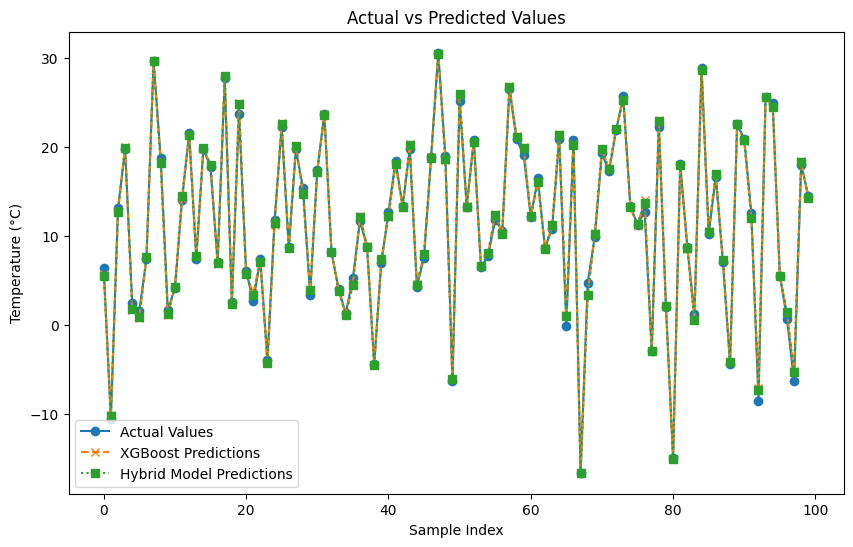

In [36]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual Values", marker='o', linestyle="-")
plt.plot(xgb_preds[:100], label="XGBoost Predictions", marker='x', linestyle="--")
plt.plot(final_preds[:100], label="Hybrid Model Predictions", marker='s', linestyle=":")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

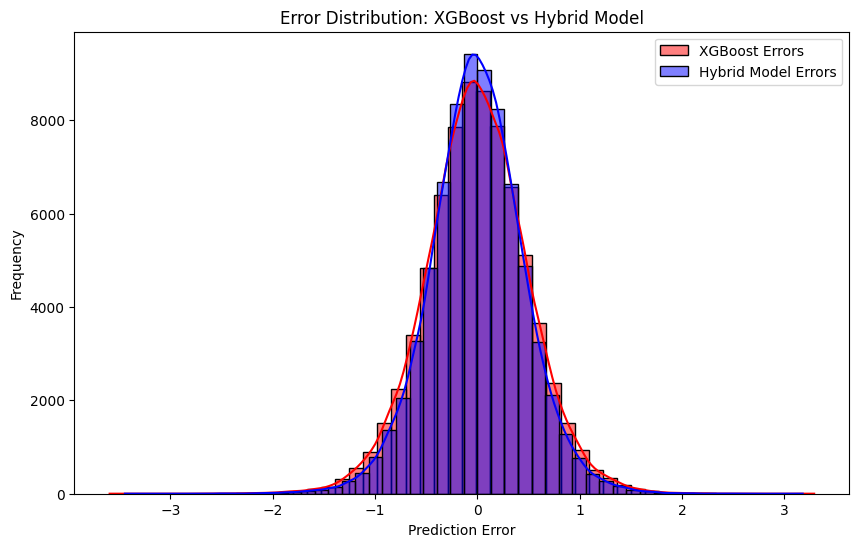

In [37]:
import seaborn as sns

# Compute residuals (errors)
xgb_errors = y_test - xgb_preds
hybrid_errors = y_test - final_preds

# Plot error distributions
plt.figure(figsize=(10, 6))
sns.histplot(xgb_errors, bins=50, color="red", label="XGBoost Errors", kde=True)
sns.histplot(hybrid_errors, bins=50, color="blue", label="Hybrid Model Errors", kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution: XGBoost vs Hybrid Model")
plt.legend()
plt.show()

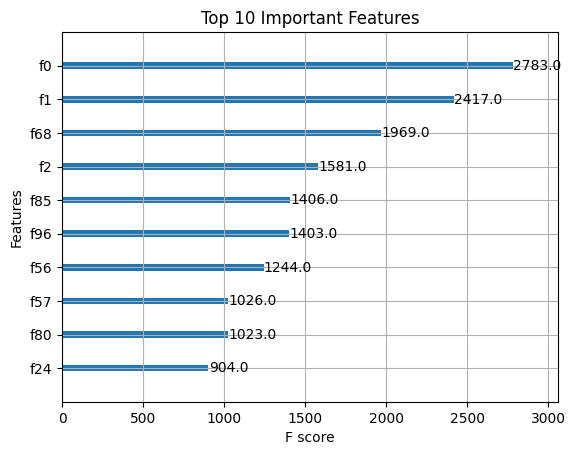

In [38]:
xgb.plot_importance(xgb_model, max_num_features=10, importance_type="weight", title="Top 10 Important Features")
plt.show()

classification matrics will be done below

definin g temparature categories


In [44]:
# Define temperature thresholds for classification
temp_thresholds = [10, 20, 30]  # Example thresholds

# Create categories based on thresholds
def categorize_temperature(temp):
  if temp < temp_thresholds[0]:
    return "Cold"
  elif temp < temp_thresholds[1]:
    return "Mild"
  elif temp < temp_thresholds[2]:
    return "Warm"
  else:
    return "Hot"

# Apply categorization to actual and predicted values
y_test_cat = y_test.apply(categorize_temperature)
final_preds_cat = pd.Series(final_preds).apply(categorize_temperature)


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test_cat, final_preds_cat)
precision = precision_score(y_test_cat, final_preds_cat, average='weighted')
recall = recall_score(y_test_cat, final_preds_cat, average='weighted')
f1 = f1_score(y_test_cat, final_preds_cat, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.9729197439684885
Precision: 0.9729342507925702
Recall: 0.9729197439684885
F1-Score: 0.9729261970620438


The results above show that the model performs very well. It correctly classifies about 97% of the cases, meaning that almost every prediction it makes is right. The precision and recall being nearly identical around 97% indicate that the model is both very accurate in predicting positive cases and good at catching most of them. The F1-score confirms this balanced, high performance.

confusion matrics

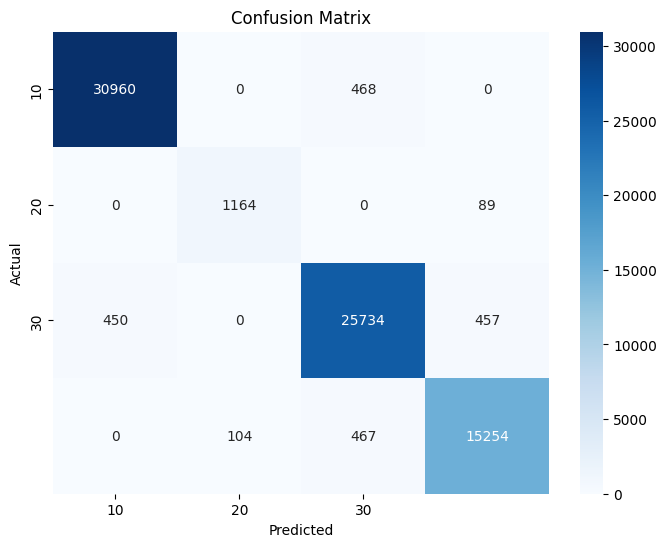

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test_cat, final_preds_cat)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=temp_thresholds, yticklabels=temp_thresholds)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

here is the above graph explanation

Interpreting the Results:

The confusion matrix heatmap visually represents how well your model is classifying temperatures into the categories you defined (Cold, Mild, Warm, Hot).

1:Diagonal Cells: The numbers in the diagonal cells (from top-left to bottom-right) represent the number of correct predictions for each category. Higher numbers here are better, as they indicate more accurate classifications.

2:Off-Diagonal Cells: The numbers in the off-diagonal cells represent incorrect predictions. For example, if there's a number in the cell corresponding to "Actual: Cold" and "Predicted: Warm," it means the model incorrectly classified some "Cold" temperatures as "Warm."

3:Color Intensity: The color intensity of each cell reflects the magnitude of the number. Darker colors generally indicate higher values (more predictions).